# Artificial Structured Datasets

This notebook is used to generate the datasets to explore the new metric beta.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import json

import numpy as np
import pandas as pd

home = str(Path.home())

RPLIB_DATA_PREFIX = os.environ.get("RPLIB_DATA_PREFIX")

if RPLIB_DATA_PREFIX is None: # Set default
    RPLIB_DATA_PREFIX=f'{home}/RPLib/data'
    
try:
    import pyrankability as pyrankability
    import pyrplib as pyrplib
except:
    print('Looking for packages in home directory')
    sys.path.insert(0,f"{home}") # Add the home directory relevant paths to the PYTHONPATH
    sys.path.insert(0,f"{home}/ranking_toolbox") # Add the home directory relevant paths to the PYTHONPATH
    sys.path.insert(0,f"{home}/RPLib") # Add the home directory relevant paths to the PYTHONPATH
    import pyrankability
    import pyrplib

import pandas as pd

from pyrplib.artificial import *

Looking for packages in home directory


## Visualizations

In [3]:
import networkx as nx
import nx_altair as nxa
def DGraph(G, pos=None):
  if not isinstance(G, nx.DiGraph):
    G = nx.DiGraph(G)

  if pos is None:
    pos = nx.drawing.layout.spring_layout(G, seed=7)
  
  nx.set_node_attributes(G, {val: val for val in list(G.nodes)}, 'labels')
  return nxa.draw_networkx(G, pos, edge_color = 'weight', node_label='labels', 
                           node_color = 'white', width=4.0, arrow_width=4,
                           edge_tooltip=['source', 'target', 'weight'])

DGraph(hillsideplusnoise(6, 0))

alt.LayerChart(...)

## Create datasets

In [5]:
number_matrices =  30

number_of_rows_columns =  20

low =  0

high = 5 

percent_links_to_remove = 10 

make_unweighted = False 

output_directory = "structured_artificial" 

percentages = [10,20,30,40,50,60,70,80,90] 


In [21]:
n = 5
r = pd.Series(np.arange(n,0,-1))
r

0    5
1    4
2    3
3    2
4    1
dtype: int64

In [22]:
ngames = 10
pyrplib.artificial.domfromranking(n,r,ngames,upset_func=lambda r1,r2: np.exp(r2) / np.sum(np.exp([r1,r2])) >= np.random.uniform())


,0,1,2,3,4
0,0,0,1,1,0
1,0,0,1,1,1
2,0,1,0,1,2
3,0,0,0,0,1
4,0,0,0,0,0


In [23]:
pyrplib.artificial.domfromranking(n,r,10000,
                                  upset_func=lambda r1,r2: (abs(r1-r2) <= 2) and np.random.uniform() > 0.5)


,0,1,2,3,4
0,0,499,459,1027,1009
1,484,0,533,484,1041
2,482,512,0,482,481
3,0,502,471,0,501
4,0,0,511,522,0


### Modify the code and the ``create`` function below

In [6]:
from datetime import datetime
import inspect

def create_dataset(create_func,get_create_options_func):
    Ds = pd.Series([]*number_matrices,dtype=object)#[pd.DataFrame(np.zeros((number_of_rows_columns,number_of_rows_columns)))])
    for i in range(number_matrices):
        Ds[i] = create()

    create_code = inspect.getsource(create_func)

    dataset = pd.Series(get_create_options_func())
    dataset["Create code"] = create_code
    dataset["Ds"] = Ds
    return dataset

datasets = {}
for percentage in percentages:
    def create():
      D = hillsideplusnoise(number_of_rows_columns,0,low=0,high=5)
      nn = 5
      D1 = emptyplusnoise(nn,percentage,low=0,high=5)
      D2 = emptyplusnoise(nn,percentage,low=0,high=5)
      D.values[-nn:,:nn] = D1
      D.values[:nn,-nn:] = D2
      if percent_links_to_remove > 0:
        D = removelinks(D,percent_links_to_remove)
      if make_unweighted:
        D = unweighted(D)
      return D

    def get_create_options():
      return {"number_matrices":number_matrices,
              "number_of_rows_columns": number_of_rows_columns,
              "low":low,
              "high":high,
              "percentage":percentage,
              "percent_links_to_remove":percent_links_to_remove,
              "make_unweighted":make_unweighted,
              }

    dataset = create_dataset(create,get_create_options)
    datasets[percentage] = dataset

In [7]:
datasets[10]

number_matrices                                                           30
number_of_rows_columns                                                    20
low                                                                        0
high                                                                       5
percentage                                                                10
percent_links_to_remove                                                   10
make_unweighted                                                        False
Create code                    def create():\n      D = hillsideplusnoise...
Ds                         0         0   1   2   3   4   5   6   7   8   ...
dtype: object

In [8]:
info_df = pd.DataFrame(columns=["Percentage of Noise",'index','obj','beta']).set_index(["Percentage of Noise",'index'])
for percentage in percentages:
    for index in datasets[percentage].Ds.index:
        D = datasets[percentage].Ds.loc[index]
        obj,details = pyrankability.rank.solve(D,method="lop",cont=True)
        info_df.loc[(percentage,index),'obj'] = obj
        Xstar = pd.DataFrame(pyrankability.common.threshold_x(details['x']),index=D.index,columns=D.columns)
        perm = details['P'][0] # select one permutation
        Xstar_r_r = Xstar.iloc[np.array(perm),np.array(perm)]
        beta = pyrankability.features.beta(Xstar_r_r)
        info_df.loc[(percentage,index),'beta'] = beta
info_df = info_df.infer_objects()

Academic license - for non-commercial use only - expires 2022-09-05
Using license file /home/jupyter-pander14/gurobi.lic


In [9]:
info_df = info_df.reset_index()
info_df

,Percentage of Noise,index,obj,beta
0,10,0,7,0.000005
1,10,1,7,0.000002
2,10,2,5,0.000004
3,10,3,0,0.000000
4,10,4,2,0.000000
...,...,...,...,...
265,90,25,21,0.000000
266,90,26,30,0.000008
267,90,27,41,0.000004
268,90,28,26,0.000003


In [10]:
info_df.drop(columns=['index']).corr()

,Percentage of Noise,obj,beta
Percentage of Noise,1.000000,0.803616,-0.039919
obj,0.803616,1.000000,-0.020582
beta,-0.039919,-0.020582,1.000000


In [63]:
number_of_rows_columns

20

In [64]:
percent_links_to_remove

10

In [28]:
from datetime import datetime
import inspect

thresholds = [1,2,3,4,5]
num_games = 1000

def create_dataset(create_func,get_create_options_func):
    Ds = pd.Series([]*number_matrices,dtype=object)#[pd.DataFrame(np.zeros((number_of_rows_columns,number_of_rows_columns)))])
    for i in range(number_matrices):
        Ds[i] = create()

    create_code = inspect.getsource(create_func)

    dataset = pd.Series(get_create_options_func())
    dataset["Create code"] = create_code
    dataset["Ds"] = Ds
    return dataset

datasets = {}
for threshold in thresholds:
    def create():
        r = pd.Series(np.arange(number_of_rows_columns,0,-1))

        D = pyrplib.artificial.domfromranking(number_of_rows_columns,r,num_games,
                                  upset_func=lambda r1,r2: (abs(r1-r2) <= threshold) and np.random.uniform() > 0.5)
        return D

    def get_create_options():
      return {"number_matrices":number_matrices,
              "number_of_rows_columns": number_of_rows_columns,
              "low":low,
              "high":high,
              "threshold":threshold,
              "num_games":num_games,
              "percent_links_to_remove":percent_links_to_remove,
              "make_unweighted":make_unweighted,
              }

    dataset = create_dataset(create,get_create_options)
    datasets[threshold] = dataset

In [56]:
info_df = pd.DataFrame(columns=["Threshold",'index','obj','beta']).set_index(["Threshold",'index'])
for threshold in thresholds:
    for index in datasets[threshold].Ds.index:
        D = datasets[threshold].Ds.loc[index]
        obj,details = pyrankability.rank.solve(D,method="lop",cont=True)
        info_df.loc[(threshold,index),'obj'] = obj
        Xstar = pd.DataFrame(pyrankability.common.threshold_x(details['x']),index=D.index,columns=D.columns)
        perm = details['P'][0] # select one permutation
        Xstar_r_r = Xstar.iloc[np.array(perm),np.array(perm)]
        beta = pyrankability.features.beta(Xstar_r_r)
        info_df.loc[(threshold,index),'beta'] = beta
        obj_lop_scip,details_lop_scip = pyrankability.rank.solve(D,method="lop",include_model=True,cont=False)
        model = details_lop_scip['model']
        model_file = pyrankability.common.write_model(model)
        max_num_solutions = 1000
        results = pyrankability.search.scip_collect(D,model_file,max_num_solutions=max_num_solutions)        
        info_df.loc[(threshold,index),'number_optimal_solutions'] = len(results['perms'])
info_df = info_df.infer_objects()
info_df = info_df.reset_index()

Running: scip_collect.sh /tmp/tmpqmczeeu3/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpqmczeeu3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp9v_c4r9s/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp9v_c4r9s/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1qnyemfl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgivssi7v/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp81f__lnl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpm65ovhjh/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpd6o9r0d8/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmprd3kubx5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp15wioxoc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpc85qcdq_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpzc_wt8ar/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgblh0_e7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmplr1ps4s3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_yqkpjpa/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp61oehpov/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpzppfqa3b/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfhtru8tn/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1zns9k6m/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmppx85fm9_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp5tx90xlc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpabq0tx54/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpier5y8ym/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpier5y8ym/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp65h78a69/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1hv8k2ka/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpixarhwdr/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1oemetca/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpuhjnim6u/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpg566ttc4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpopfceoq5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpqevqo2cg/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp450zkd0w/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpsqs_lex7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmptgl1ajw2/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9s2srka0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpjbv5fejb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp5ka7uqwf/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp97eoyuxa/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpvv5k1lt_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmplmgnh99z/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpv5vf0w7e/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpnedror5n/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpbez73_ec/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpg1rsvn9t/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpg1rsvn9t/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpsl3x4g_d/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpsl3x4g_d/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpef_wrghb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpro8pmsux/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmps02c7313/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp514yv9i9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpaj1js9f6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpyybyapn8/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpvaisz4k_/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpvaisz4k_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp8auluczk/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpkhf2uxh0/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpkhf2uxh0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpo9yazfnp/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpo9yazfnp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmphhc57wgy/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmphhc57wgy/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp6kitkxxa/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp6kitkxxa/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp5ekvc6ue/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp5ekvc6ue/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmph7lvja11/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7k6p0hi9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpcnd5sf4z/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp5qypb47o/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpwv8__geg/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpd700_v20/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpd700_v20/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpe6_lbq6u/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp58fc3l90/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp58fc3l90/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpi0foi9l1/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7e9205ck/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpn97rcjxo/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpnj80hk4f/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpoztwwp2i/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp290qx83s/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0cw3l2si/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0oey2xo3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpfl3mjkp8/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpfl3mjkp8/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp_lch3i3b/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp_lch3i3b/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpvj6n8eax/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpzty0svnm/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpzty0svnm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpih5zeska/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp5rh2z_t_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfjp3ai__/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpn32ic3h6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpygyl5sou/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpuju_lwso/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpuju_lwso/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp24u6t4pl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp24994fvx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgqa8l9g0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpwb6hqa5v/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpnya3d56f/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpnya3d56f/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpf04gj5b_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpiipgu8rd/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpu895p7gj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpq2egmrbn/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_zbj6m3w/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpqvseuozj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp6z5dha19/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp6z5dha19/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpw47bowfb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7pqwi_0z/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp_je9k2ya/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp_je9k2ya/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp14_6rsy_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpszevg2g2/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpszevg2g2/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp60ff8bf0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpr3spktpq/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpr3spktpq/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp3jsbp8hr/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp3jsbp8hr/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpjgra6xuc/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpjgra6xuc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpbmnbzxnf/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpbmnbzxnf/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpvg6n1k9n/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpncy72pqq/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpumiyr4af/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpumiyr4af/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfkite54_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpln9_ed6v/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpi9s02cfr/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp3le6lest/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpxnv_363g/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpykq27ov0/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpykq27ov0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmphuqd7lhh/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpcbp_olrp/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpcbp_olrp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpkz8ulu83/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp2n08_fst/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp8dfaqp1l/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp8dfaqp1l/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_t65bq97/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp4nsq681r/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp4nsq681r/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp1bv5djr9/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp1bv5djr9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpmc6p3md4/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpmc6p3md4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfldjykvv/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp6p83lfw7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp8d8e7hcq/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp3m4ikmd4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpeg83aiku/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpkdbjfj4u/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpkdbjfj4u/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp4zmsh1ho/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpipyi5vs0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpqqms5vmy/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpqqms5vmy/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpiixv10fl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp8qy5mrz9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpktczuexh/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpktczuexh/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp48oydu1p/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp48oydu1p/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpv8pphf1m/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpplhlgiwp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp6g52j7qj/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp6g52j7qj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_rdxp741/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpbosbrjcl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpq6b6rx3a/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpq6b6rx3a/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgru8uhrt/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpqdnkeej3/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpqdnkeej3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpt1qe4wdv/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpf1_hd5ej/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpf1_hd5ej/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0_brz3zt/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpwzpl_1qe/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpwzpl_1qe/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp9bqzknjc/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp9bqzknjc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpv2de37s4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


In [61]:
info_df.drop(columns=['index']).corr()['number_optimal_solutions']

Threshold                   0.162744
obj                         0.184372
beta                        0.445656
number_optimal_solutions    1.000000
Name: number_optimal_solutions, dtype: float64

In [47]:
import os
os.environ["PATH"] = "/opt/tljh/user/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/local/SCIPOptSuite/bin:/home/jupyter-pander14/ranking_toolbox"

In [50]:
info_df = pd.DataFrame(columns=["Threshold",'index','obj','beta']).set_index(["Threshold",'index'])
for threshold in thresholds:
    for index in datasets[threshold].Ds.index:
        D = datasets[threshold].Ds.loc[index]
        obj_lop_scip,details_lop_scip = pyrankability.rank.solve(D,method="lop",include_model=True,cont=False)
        model = details_lop_scip['model']
        model_file = pyrankability.common.write_model(model)
        max_num_solutions = 1000
        results = pyrankability.search.scip_collect(D,model_file,max_num_solutions=max_num_solutions)        
        info_df.loc[(threshold,index),'number_optimal_solutions'] = len(results['perms'])
info_df = info_df.infer_objects()
info_df = info_df.reset_index()

Running: scip_collect.sh /tmp/tmpskdr1urk/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpskdr1urk/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp_6bxj9w6/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp_6bxj9w6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9gcpaqcz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpl6afutim/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpi850jpg6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpn3_tgf2y/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmptd9i2jcd/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmprgjsj8kv/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmprv2hmrvb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpbq2mxl6s/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp6w728hjc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp95arnbkq/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0rdlqwo7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_asg2yb5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9upuppp8/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmprzjel4mw/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpo4e1k18o/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmps1tk2mi2/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpq_nbarzk/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpby6uik3n/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp3o1g35rl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0rqmv0la/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmphd6jv_zp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpdn7_w_s5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpxdpr5gsi/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpdr9ifpcb/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpdr9ifpcb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp6zvjusnf/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp6q6prh5n/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgdhtxwz4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpzydrt4z_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpviwxhhxz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7qlw7ms3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpo2kywdzc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpjyg6ohi1/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmplsnq4459/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpx6vi6wd9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpxk490jsi/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmphadai76v/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpoo19qtf5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpf0s62qf_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpzp5v7dpm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpd64ss6ic/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9cdvvcqg/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp_tus45wx/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp_tus45wx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpm20t9lm2/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpre9zwsvm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0s8zlcjn/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpny7x1hwi/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpozv9njhj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp4q52vs01/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpmo484atr/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpmo484atr/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpphwghcm5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmprrd3rfd0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpb_52qgtm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpla4f4pt4/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpla4f4pt4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpkeguuqkz/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpkeguuqkz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpoijel0wm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp0issf_07/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpz504f2y3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpqkab6e9s/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp4w7td3me/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpud97mpi4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9ceot9kv/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpx9l5vno_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp2vb7ik8f/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp18efob4l/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpa9okyv6x/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmptr0tpag7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7ofe96q3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpcfhrxev6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmppx18jegw/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpl0mkdzdz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp40syzhxx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpy4gfi2hz/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpy4gfi2hz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp00u33bg_/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp00u33bg_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp_lvfft1y/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpirb5z9yc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmph9mphoq0/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmph9mphoq0/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpjt153abz/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpmj2s123w/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfz57_k1w/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpmmbd5czk/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp7di2r3yk/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpv81xzj8i/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmppkuhywj1/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmppc_l3wy5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmphe5lu42b/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpf1wh0cgl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpajp0t14f/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpyitnljxx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpmbcso2zy/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1tr0ecjj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpa7lzabid/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp4qx8qogw/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpiqf702lp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpn8omktij/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp3nossher/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmph8zv1x_b/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpgk7qn3zp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp7h0qfztu/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp7h0qfztu/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp27i69n7a/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpuo1d5qx_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmph_5_0l82/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpj3n7y4on/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpj3n7y4on/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpqu1eimoc/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpzt8se815/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpumencdb3/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpnkzswh5i/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1i3ytylf/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpiy9hpix6/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp2_drce36/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp2kx_ka_7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpthxnhtki/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpjtjaa9ku/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpy355qp5k/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpo1ojmw87/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmps362fuu4/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpjqxgz1r5/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpn5cxrwdx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1da5hg88/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpe6tcl8mb/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp1dozrm03/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpjz3c0u6d/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpjz3c0u6d/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmphrb0avol/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmplzbf0i2m/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpr3ehrgce/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpou9rkl37/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpp4nk1fqj/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpp4nk1fqj/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp4vdpyh5v/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpplh85sa9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpppba83d9/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp1zcayvir/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp1zcayvir/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpmwt_x2dm/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpw_rw3inx/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfo25kywp/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpemxpkoyd/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmplp44coht/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpwa7eyhkl/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpmm8j401d/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpkfcdydkn/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpnxwrtg4n/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpadb6cmje/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpfvb3ei8i/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpedi9dkl7/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpu644d7vw/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmp6n2svd2c/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmp6n2svd2c/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp2ctlsaxf/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


Running: scip_collect.sh /tmp/tmpx_gz2ai_/model.mps.fixed.mps /tmp/tmp2tk6gdfx/model.solutions 1000
STDOUT:
Model file: /tmp/tmpx_gz2ai_/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programm

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmpnqp4x6sv/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


STDOUT:
Model file: /tmp/tmp9uy6woit/model.mps.fixed.mps
Solutions file: /tmp/tmp2tk6gdfx/model.solutions
SCIP version 7.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.2] [GitHash: dafb536cfd]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline 7.0         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 5.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 3623dbc0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for intege

/home/jupyter-pander14/ranking_toolbox/pyrankability/search.py:740: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  solutions = pd.read_csv(solution_file,sep=', ')


In [55]:
info_df.set_index(['Threshold'

,Threshold,index,obj,beta,number_optimal_solutions
0,1,0,NaN,NaN,54.0
1,1,1,NaN,NaN,4.0
2,1,2,NaN,NaN,4.0
3,1,3,NaN,NaN,8.0
4,1,4,NaN,NaN,8.0
...,...,...,...,...,...
145,5,25,NaN,NaN,2.0
146,5,26,NaN,NaN,70.0
147,5,27,NaN,NaN,15.0
148,5,28,NaN,NaN,2.0


<AxesSubplot:ylabel='Frequency'>

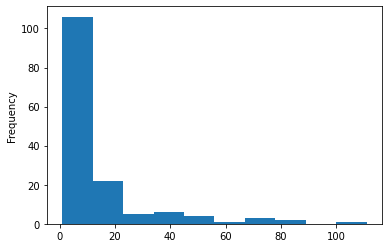

In [52]:
info_df['number_optimal_solutions'].plot.hist()

In [53]:
info_df.corr()

,Threshold,index,obj,beta,number_optimal_solutions
Threshold,1.000000e+00,-4.643826e-17,NaN,NaN,0.162744
index,-4.643826e-17,1.000000e+00,NaN,NaN,-0.041491
obj,NaN,NaN,NaN,NaN,NaN
beta,NaN,NaN,NaN,NaN,NaN
number_optimal_solutions,1.627441e-01,-4.149078e-02,NaN,NaN,1.000000
